In [1]:
import random
import numpy as np

from qmlab.preprocessing import parse_biomed_data_to_df, parse_biomed_data_to_ndarray, reduce_feature_dim
from qmlab.plots.plot_data import plot_2d_data_with_train_test_split
from qmlab.plots.plot_model import plot_decision_boundaries
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn import metrics
from qiskit_algorithms.utils import algorithm_globals

%matplotlib inline

In [2]:
random_state = 12345 
algorithm_globals.random_seed = random_state
np.random.seed(random_state)

In [4]:
X, y = parse_biomed_data_to_ndarray("sobar_new")
X = reduce_feature_dim(X, num_features=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(57, 2)
(15, 2)
(57,)
(15,)


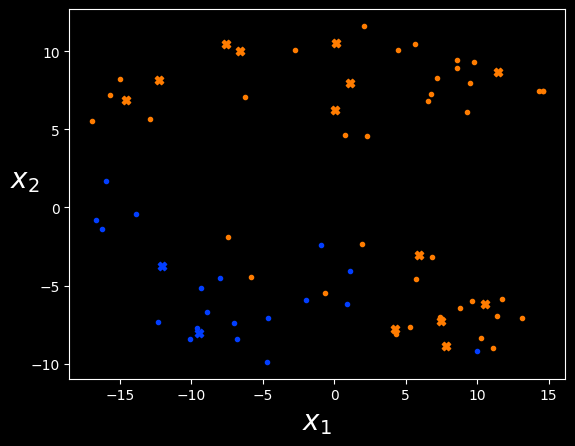

In [5]:
plot_2d_data_with_train_test_split(X_train, y_train, X_test, y_test)

Best grid search parameters: {'C': 6, 'gamma': 0.05}
Best training score: 0.9298029556650247


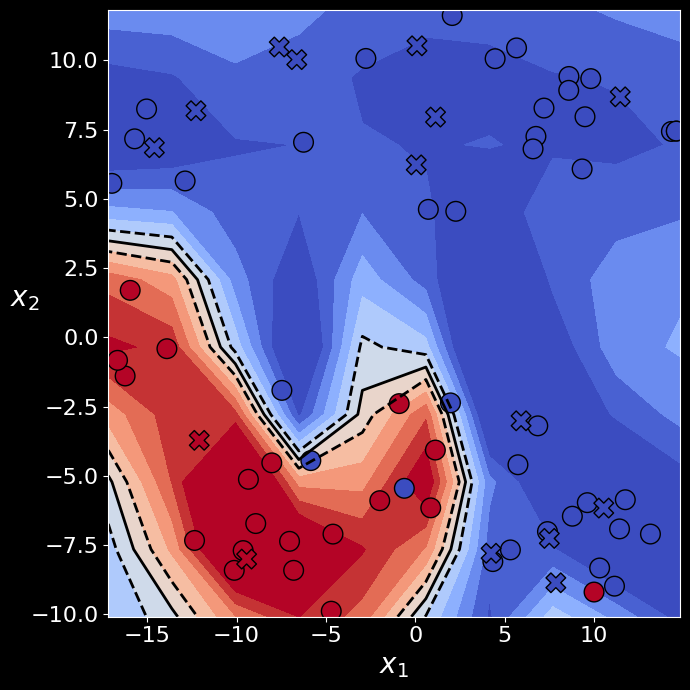

In [6]:
param_grid = {
    "gamma": [
        0.001,
        0.005,
        0.01,
        0.05,
        0.1,
        0.25,
        0.5,
        1.0,
        1.2,
        1.4,
        1.6,
        1.8,
        2.0,
        5.0,
        10.0,
    ],
    "C": [1, 2, 4, 6, 8, 10, 100],
}
gs = GridSearchCV(
    estimator=SVC(kernel="rbf", random_state=random_state),
    param_grid=param_grid,
    scoring="accuracy",
    n_jobs=4,
    cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=random_state),
)
gs.fit(X_train, y_train)

print("Best grid search parameters:", gs.best_params_)
print("Best training score:", gs.best_score_)
clf = gs.best_estimator_

clf.fit(X_train, y_train)

plot_decision_boundaries(clf, X_train, y_train, X_test, y_test)

In [7]:
y_pred = clf.predict(X_train)
training_acc = metrics.balanced_accuracy_score(y_train, y_pred)
y_pred = clf.predict(X_test)
test_acc = metrics.balanced_accuracy_score(y_test, y_pred)
print("Prediction scores: \n")
print("\t\tTrain\tTest")
print(f"Accuracy:\t{training_acc:.2f}\t{test_acc:.2f}")

Prediction scores: 

		Train	Test
Accuracy:	0.96	1.00
